# Notes on Adam: A method for Stochastic Optimization
## Authors Diederik P. Kingma, Jimmy Ba
### Notes: Michael Holtz

### Abstract
The authors propose Adam and Adamax, algorithms for first-order gradient based optimization of stochastic objective functions, based on adaptive estimations of lower-order moments. They claim that it is efficient, easy to understand, and performs comperably if not better than other optimization functions.

### Introduction

The authors introduce optimization problems as essential to science and engineering. They note that gradient descent is a good way of solving these problems, given the objective function is differentible w.r.t. its parameters. SGD has been shown to be efficient and effective in deep learning tasks. They propose adam as a competitor to SGD, RMSprop, and AdaGrad.

In [1]:
def Adam(f, f_grad, theta, convergence_criteria, alpha = .001, beta1 = .9, beta2 = .999, eps = 10 ** -8):
    m, v, t = 0, 0, 0
    while not convergence_criteria:
        t = t + 1
        g = f_grad(theta)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g ** 2
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        theta = theta - alpha * m_hat / (v_hat ** .5 + eps)
    return theta

### Algorithm
The algorithm is proposed to find a minimum of $f(\theta)$, a stochastic scalar function differentiable with respect to $\theta$. The stochasticity may come from the evaluation of random samples (minibatches) as in the case of machine learning training. The algorithm updates exponential moving averages of the gradient and the squared gradient, controled by the hyper-parameters $\beta_1$ and $\beta_2$. The moving averages are estimates for the first and second moments of the gradient (mean and uncentered variance). As these estimates are initialized to 0, the estimates are biased towards 0. This is corrected for in $\hat{m}$ and $\hat{v}$ where the bias is corrected for.  

### Update Rule
The stepsize in Adam's update rule is $\alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}}}$ this stepsize is bound by $\alpha \cdot \frac{(1 - \beta_1)}{\sqrt{1 - \beta_2}}$ if $(1 - \beta_1) > (\sqrt{1-\beta_2})$ and $\alpha$ otherwise. This means that the effective magnitude of the steps taken in parameter space are approximately bounded by the step size hyper-parameter. This value can be thought of as a region anound the current parameters in the parameter space within which the user trusts that the gradient at the current parameters is useful.


### Initial Bias Correction and Convergence Analysis
The authors derive the bias correction term for the second moment, and evaluate the convergence criteria of the algorithm.

### The rest of the paper is filled with examples of Adam use, showing adam outperforming other optimization algorithms such as SGD, Adagrad, and RMSprop

In [2]:
def AdaMax(f, f_grad, theta, convergence_criteria, alpha = .001, beta1 = .9, beta2 = .999, eps = 10 ** -8):
    m, v, t = 0, 0, 0
    while not convergence_criteria:
        t = t + 1
        g = f_grad(theta)
        m = beta1 * m + (1 - beta1) * g
        u = max(beta2 * u, abs(g))
        theta = theta - alpha/(1 - beta1 ** t) * m / (u + eps)
    return theta

### Experiment with Adam vs AdaMax vs SGD vs RMSprop with cnn on mnist

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

print('Size of training set:', len(trainset))
print('Size of testing set:', len(testset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 32.4MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.84MB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.46MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Size of training set: 60000
Size of testing set: 10000


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(6 * 4 * 4, 10)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 6 * 4 * 4)
        x = self.linear1(x)
        x = self.softmax(x)
        return x

In [6]:
def train_model(optimizer):
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters())

    train_loss = []
    test_loss = []

    for epoch in tqdm(range(10)):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(trainloader))

        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        test_loss.append(running_loss / len(testloader))

    return train_loss, test_loss

In [7]:
optimizers = [optim.SGD, optim.Adam, optim.Adamax, optim.RMSprop]
train_losses = []
test_losses = []
for optimizer in optimizers:
    print(optimizer.__name__)
    train_loss, test_loss = train_model(optimizer)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

SGD


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


Adam


100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


Adamax


100%|██████████| 10/10 [01:08<00:00,  6.90s/it]


RMSprop


100%|██████████| 10/10 [01:12<00:00,  7.20s/it]


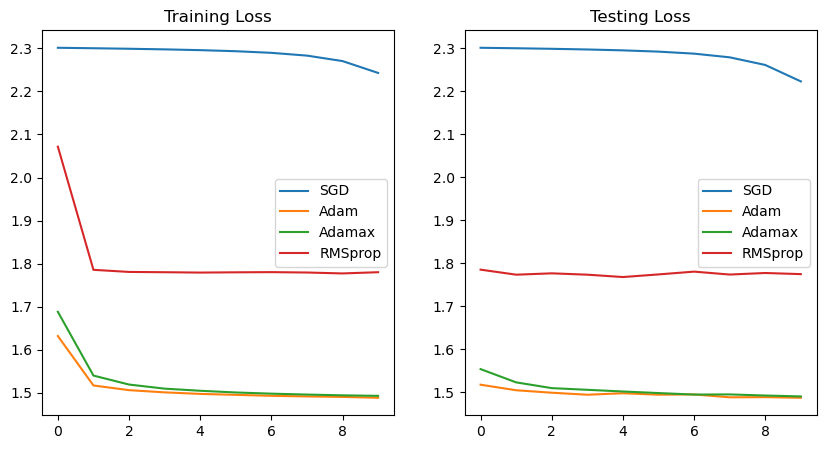

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
for i in range(len(optimizers)):
    axs[0].plot(train_losses[i], label = optimizers[i].__name__)
    axs[0].legend()
    axs[0].set_title('Training Loss')
    axs[1].plot(test_losses[i], label=optimizers[i].__name__)
    axs[1].legend()
    axs[1].set_title('Testing Loss')
plt.show()